<a href="https://colab.research.google.com/github/haebarassi/PillOCR/blob/main/pillIdentifier_%EC%A7%84%ED%96%89%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://davelogs.tistory.com/70
https://yanggyu.tistory.com/?page=2


# 데이터셋 받아오기

- 정신신경용제 중에서 품목일련번호로 구분
- 의사가 등록한 품목일련번호 (처방전을 찍어서 올리는 방식?)에 해당하는 약물을 체크리스트로 갖고, 알약 이미지를 올리면 리스트 내에 존재하는 데이터인지 체크한다.
- 사용자가 찍어서 올린 알약 사진의 '품목일련번호'의 '표시앞' 혹은 '표시뒤'와 동일한지 체크

# Install Tesseract

In [1]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [2]:
!tesseract --version

tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [3]:
!sudo apt-get install tesseract-ocr-eng tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-eng is already the newest version (4.00~git24-0e00fe6-1.2).
tesseract-ocr-kor is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [4]:
!tesseract --list-langs

List of available languages (3):
kor
eng
osd


Install PyTesseract

In [5]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Google Drive Mount & Test Image Load

In [6]:
import cv2
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
pill_df = pd.read_csv('/content/drive/MyDrive/pillAlgorithm/PillOpenData.csv')

In [51]:
%cd '/content/drive/MyDrive/pillAlgorithm'

/content/drive/MyDrive/pillAlgorithm


## EDA

In [52]:
pill_df.describe()

,품목일련번호,업소일련번호,이미지생성일자(약학정보원),품목허가일자,Unnamed: 29
count,2.478700e+04,2.478700e+04,2.478700e+04,2.478700e+04,0.0
mean,2.010275e+08,3.444061e+07,2.013600e+07,2.010297e+07,NaN
std,9.131192e+05,1.708614e+08,5.710433e+04,9.132423e+04,NaN
min,1.959000e+08,1.954000e+07,2.004113e+07,1.959011e+07,NaN
25%,2.005016e+08,1.958000e+07,2.008090e+07,2.005061e+07,NaN
50%,2.013084e+08,1.965000e+07,2.014112e+07,2.013073e+07,NaN
75%,2.017074e+08,1.990002e+07,2.019033e+07,2.017101e+07,NaN
max,2.022037e+08,2.022005e+09,2.022111e+07,2.022093e+07,NaN


In [53]:
pill_df.columns

Index(['품목일련번호', '품목명', '업소일련번호', '업소명', '성상', '큰제품이미지', '표시앞', '표시뒤', '의약품제형',
       '색상앞', '색상뒤', '분할선앞', '분할선뒤', '크기장축', '크기단축', '크기두께', '이미지생성일자(약학정보원)',
       '분류번호', '분류명', '전문일반구분', '품목허가일자', '제형코드명', '표기내용앞', '표기내용뒤', '표기이미지앞',
       '표기이미지뒤', '표기코드앞', '표기코드뒤', '변경일자', 'Unnamed: 29'],
      dtype='object')

In [54]:
# pill_df.count()

- 필요한 정보 : 약 이미지, 약 이름
- 사용 dataset : 의약품안전나라(공공데이터개방 낱알식별목록 csv파일)
- 큰제품이미지 컬럼 : 알약 이미지 파일
  - 앞 뒤 이미지 쌍으로 되어 있으므로 절반으로 나누어 활용
- 품목명 : 알약 품목명
- 의약품제형 : 알약 모양
- 분류명 : 어떤 종류의 의약품인지
  - 우리가 판단하고자 하는 분류는: 정신신경용제

1) 등록된 알약들의 품목명은 모두 다름을 알 수 있다. 

In [55]:
pill_df['품목명'].nunique()

24737

In [56]:
pill_df['분류명'].unique()

array(['기타의소화기관용약', '항악성종양제', '최면진정제', '혈압강하제', '동맥경화용제', '해열.진통.소염제',
       '정신신경용제', '기타의중추신경용약', '기타의비뇨생식기관및항문용약', '치과구강용약', '기타의순환계용약',
       '간장질환용제', '혼합비타민제(비타민AD혼합제제를제외)', '진해거담제', '소화성궤양용제', '칼슘제',
       '기타의비타민제', '기타의화학요법제', '무기질제제', '기타의자양강장변질제', '하제|완장제', '골격근이완제',
       '따로분류되지않는대사성의약품', '진경제', '항전간제', '제산제', '주로그람양성|음성균에작용하는것',
       '주로그람양성균|리케치아|비루스에작용하는것', '비타민C및P제', '단백아미노산제제', '항히스타민제', '구충제',
       '당뇨병용제', '혈관확장제', '기타의외피용약', '정장제', '비타민E및K제', '기타의알레르기용약',
       '자격요법제(비특이성면역억제제를포함)', '난포호르몬제및황체호르몬제', '효소제제', '기타의호흡기관용약',
       '안과용제', '합성마약', '통풍치료제', '종합대사성제제', '따로분류되지않고치료를주목적으로하지않는의약품',
       '부정맥용제', '비타민B제(비타민B1을제외)', '기타의혈액및체액용약', '비타민B1제', '건위소화제',
       '자율신경제', '아편알카로이드계제제', '혈액응고저지제', '진훈제', '피임제', '항원충제', '기타의조제용약',
       '최토제|진토제', '뇌하수체호르몬제', '각성제|흥분제', '해독제', '비타민A및D제',
       '기타의조직세포의기능용의약품', '기타의항생물질제제(복합항생물질제제를포함)', '부신호르몬제', '이비과용제',
       '강심제', '화농성질환용제', '모발용제(발모|탈모|염모|양모제)',
       '주로그람양성|음성균|리케치아|비루스에작용하는것', '지혈제', '항결핵제', '주로항

2) 그 중에서 정신신경용제에 해당하는 알약의 수는 912개

In [57]:
pill_df[pill_df['분류명']=='정신신경용제'].count()

품목일련번호            912
품목명               912
업소일련번호            912
업소명               912
성상                912
큰제품이미지            912
표시앞               912
표시뒤               912
의약품제형             912
색상앞               912
색상뒤               912
분할선앞              912
분할선뒤              912
크기장축              912
크기단축              912
크기두께              912
이미지생성일자(약학정보원)    912
분류번호              912
분류명               912
전문일반구분            912
품목허가일자            912
제형코드명             912
표기내용앞             912
표기내용뒤             912
표기이미지앞            912
표기이미지뒤            912
표기코드앞             912
표기코드뒤             912
변경일자              912
Unnamed: 29         0
dtype: int64

## Import Packages

In [58]:
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np
import os

In [59]:
os.listdir = '/content/drive/MyDrive/pillAlgorithm'

In [60]:
os.listdir

'/content/drive/MyDrive/pillAlgorithm'

## preprocessing

### NA 문자를 NAN으로 인식하는 문제

In [61]:
pill_df.loc[pill_df['표시앞'].isnull(),'표시앞'] = 'NA'

In [62]:
pill_df.loc[pill_df['표시뒤'].isnull(),'표시뒤'] = 'NA'

### x_data, y_data 정의

In [63]:
x_data = pill_df['큰제품이미지']

In [64]:
x_data.count()

24787

In [65]:
y_data = pill_df['표시앞']+pill_df['표시뒤']

In [66]:
y_data.count()

24787

### '분할선'이라는 문자의 제거 필요성

In [67]:
y_data.str.contains('분할선')

0        False
1        False
2        False
3         True
4         True
         ...  
24782    False
24783    False
24784    False
24785     True
24786    False
Length: 24787, dtype: bool

In [68]:
y_data = y_data.str.replace('분할선','|')

### 외곽선 검출 (contour)

In [69]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [173]:
import random
index = random.randint(0,14000)

In [174]:
url = x_data[index]

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 

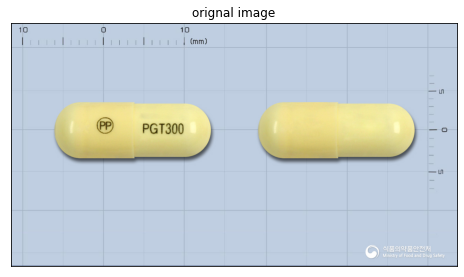

In [175]:
plt_imshow("orignal image", org_image)

In [176]:
org_image.shape

(709, 1299, 3)

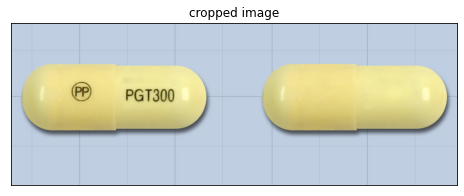

In [177]:
x = 100
y = 130
w = 1100
h = 400
org_image = org_image[y: y+h, x: x+w]
plt_imshow("cropped image", org_image)

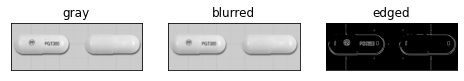

In [178]:
image = org_image.copy()
image = imutils.resize(image, width=500)
ratio = org_image.shape[1] / float(image.shape[1])

# 이미지를 grayscale로 변환하고 blur를 적용
# 모서리를 찾기위한 이미지 연산
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(image, (5, 5,), 0)
edged = cv2.Canny(blurred, 30, 30)

plt_imshow(['gray', 'blurred', 'edged'], [image, blurred, edged])

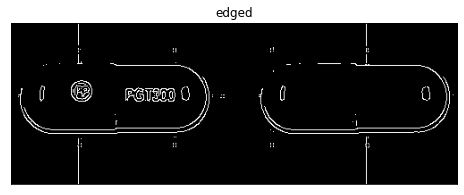

In [179]:
plt_imshow(['edged'],[edged])

엣지 이미지로 closed 찾기

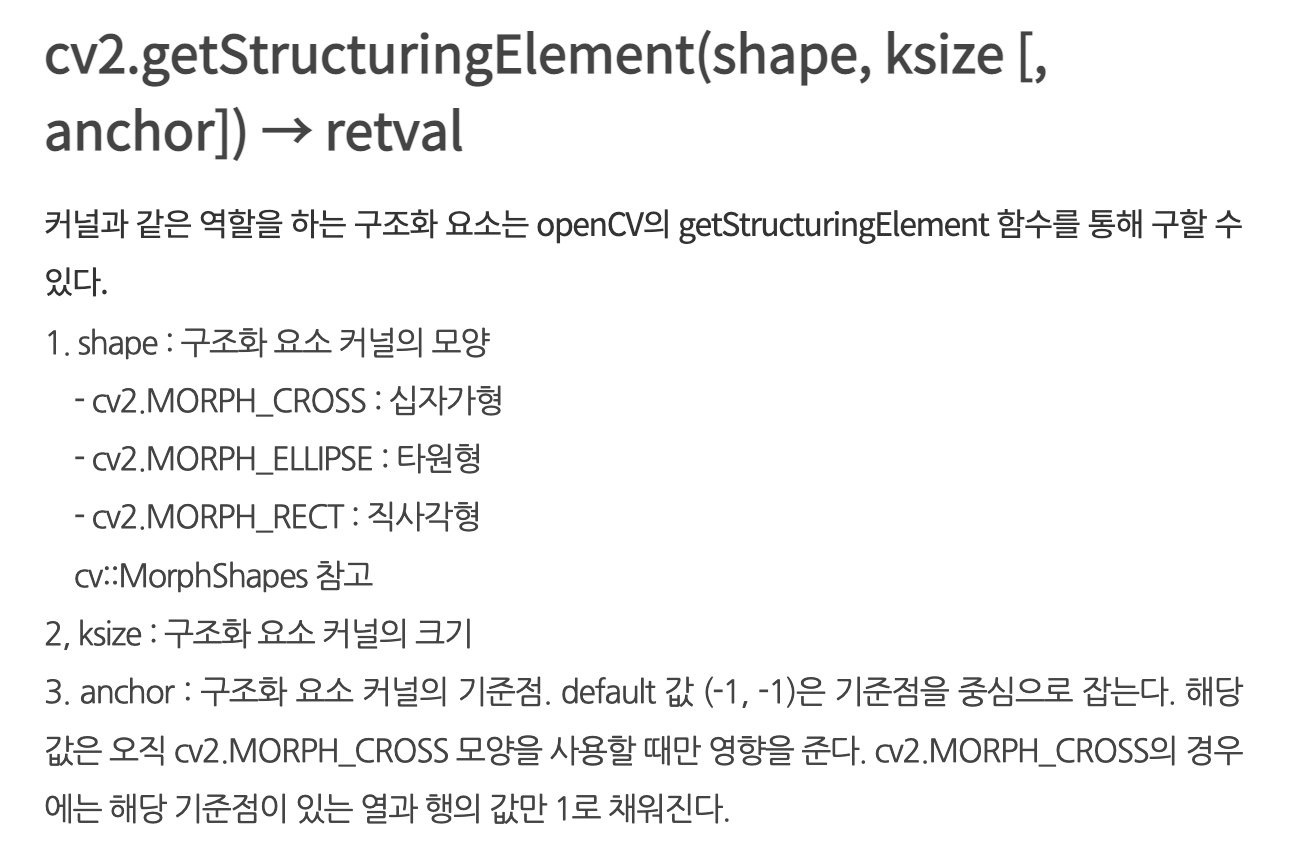

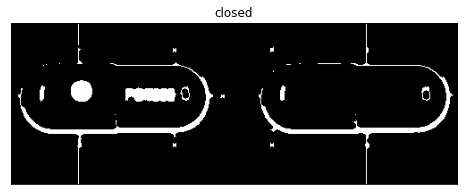

-1

In [180]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

plt_imshow(['closed'],[closed])
cv2.waitKey(0)

추가하기: 컨투어 단순화
- 근사 값으로 컨투어 찾는 코드 
  - approx = cv2.approxPolyDP(contour, epsilon, closed)

   - contour = 대상 컨투어 좌표

   - epsilon = 근사 값 정확도, 오차 범위

   - closed = 컨투어의 닫힘 여부
- https://dsbook.tistory.com/227
- approx1

컨투어 찾기

- edged copy 이미지로 넣어줄 것 

In [181]:
contours, _ = cv2.findContours(edged.copy(),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
total = 0

In [182]:
# 컨투어 closed로 넣어주는 다른버전
#contours, _ = cv2.findContours(closed.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#total = 0

In [183]:
# 최소한의 타원 표시
#ellips = cv2.fitEllipse(contours)
#cv2.ellipse(closed, ellips,(0,255,255),3)

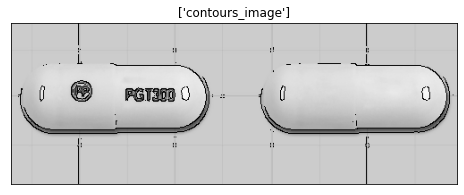

In [184]:
contours_image = cv2.drawContours(image, contours, -1, (0,0,0),thickness=cv2.FILLED)
plt_imshow(['contours_image'],contours_image)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [185]:
contours_xy = np.array(contours)
contours_xy.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(91,)

In [186]:
# x의 min과 max 찾기
x_min, x_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
        x_min = min(value)
        x_max = max(value)
print(x_min)
print(x_max)
 
# y의 min과 max 찾기
y_min, y_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
        y_min = min(value)
        y_max = max(value)
print(y_min)
print(y_max)

8
494
0
180


In [187]:
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [188]:
createDirectory('preprocessed_data')

In [189]:
%cd '/content/drive/MyDrive/pillAlgorithm/preprocessed_data'

/content/drive/MyDrive/pillAlgorithm/preprocessed_data


In [190]:
pwd

'/content/drive/MyDrive/pillAlgorithm/preprocessed_data'

In [191]:
%ls

preprocessed_13572.jpg  preprocessed_6963.jpg


In [192]:
# image trim 하기
x = x_min
y = y_min
w = x_max-x_min
h = y_max-y_min

In [193]:
img_trim = image[y:y+h, x:x+w]
filename = 'preprocessed_'+str(index)+'.jpg'
cv2.imwrite(filename, img_trim)
preprocessed_image = cv2.imread(filename)

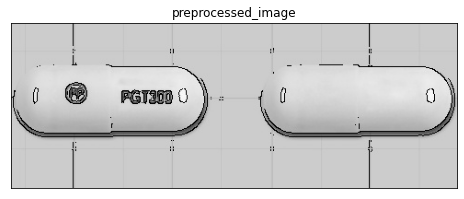

In [194]:
plt_imshow(['preprocessed_image'],[preprocessed_image])
cv2.waitKey(0)
cv2.destroyAllWindows()

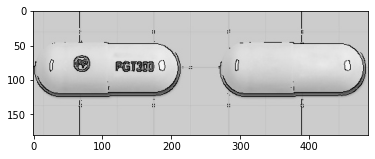

In [195]:
plt.imshow(preprocessed_image)

In [196]:
# text = pytesseract.image_to_string('preprocessed_image.jpg', lang ='kor+eng',config=options)

In [197]:
pytesseract.pytesseract.tesseract_cmd

AttributeError: ignored

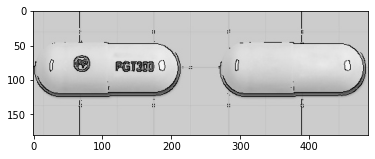

In [198]:
custom_config = f'--oem 3--psm 3'
result = pytesseract.image_to_string(preprocessed_image, lang="kor+eng+num", config=custom_config)
#print(f'oem = {oem}, psm = {psm}')
print()
print(result)
plt.imshow(preprocessed_image)

In [199]:
type(preprocessed_image)

numpy.ndarray

In [200]:
from PIL import Image
from google.colab.patches import cv2_imshow

In [201]:
pil_img = Image.fromarray(preprocessed_image)

In [202]:
type(pil_img)

PIL.Image.Image

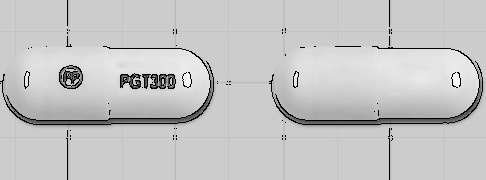

In [203]:
cv2img = cv2_imshow(preprocessed_image)

In [204]:
%ls

preprocessed_13572.jpg  preprocessed_6963.jpg  preprocessed_7589.jpg


In [205]:
%cd

/root


In [206]:
# from pytesseract import *

In [207]:
# pil, ndarray 서로 변환 관련.....
# def conv_pil_to_cv(img: Image) -> np.ndarray:
#     return np.array(img.convert('RGB'))[:, :].copy()


# def conv_cv_to_pil(array: np.ndarray) -> Image:
#     return Image.fromarray(array)

[INFO] OCR결과:
       

@0 — PGT300

 





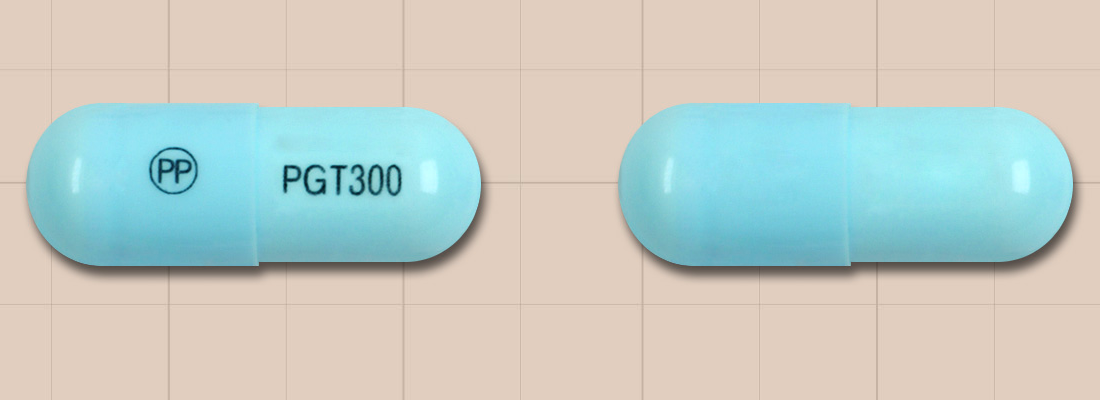

In [208]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB),lang='kor+eng+num',config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")
cv2_imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))

[INFO] OCR결과:
       

@0 — PGT300

 





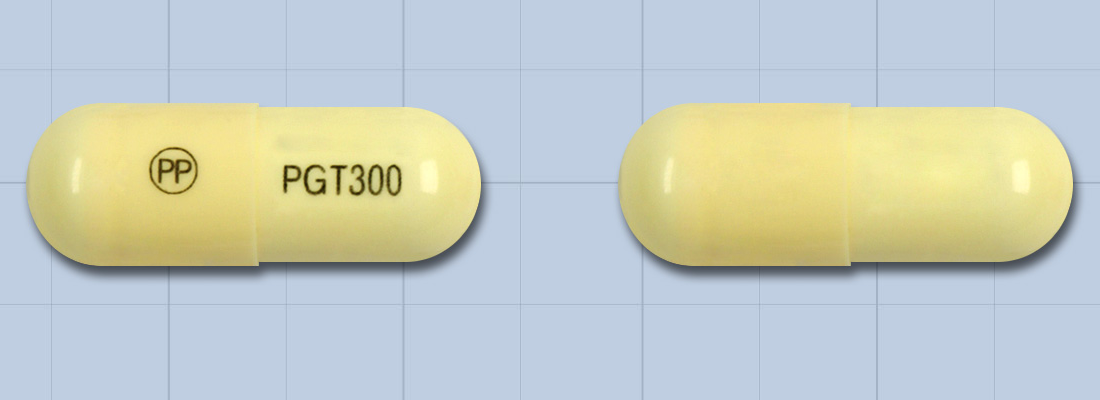

In [209]:
text = pytesseract.image_to_string(org_image,lang='kor+eng+num',config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")
cv2_imshow(org_image)

[INFO] OCR결과:





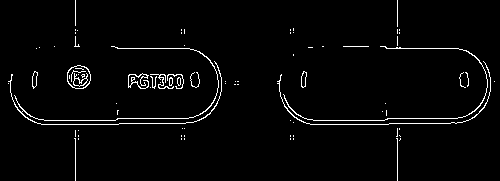

In [210]:
text = pytesseract.image_to_string(edged,lang='kor+eng+num',config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")
cv2_imshow(edged)

[INFO] OCR결과:
Poot ted
a {1 : a)





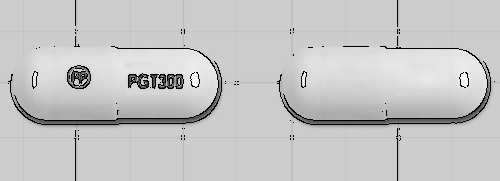

In [211]:
text = pytesseract.image_to_string(contours_image,lang='kor+eng+num',config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")
cv2_imshow(contours_image)

[INFO] OCR결과:
Pot
= {0 a)





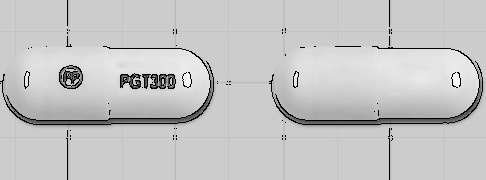

In [212]:
text = pytesseract.image_to_string(preprocessed_image,lang='kor+eng+num',config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")
cv2_imshow(preprocessed_image)

[INFO] OCR결과:
000





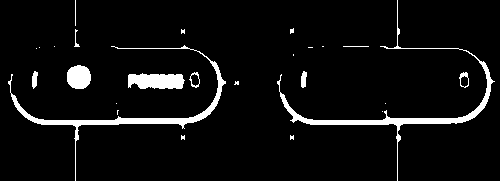

In [213]:
text = pytesseract.image_to_string(closed,lang='kor+eng+num',config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")
cv2_imshow(closed)

## train set, test set 나누기

In [214]:
x_train = x_data[0:20000]
y_train = y_data[0:20000]

x_val = x_data[20001:22500]
y_val = y_data[20001:22500]

x_test = x_data[22501:]
y_test = y_data[22501:]

# Tesseract